In [1]:
import numpy as np
import torch
import torch.optim as optim
from utils.mcmc_sampler import mcmc_step
import matplotlib.pyplot as plt
from models.cnn import J1J2CNNRegressor1D as CNN
from models.complex_cnn import J1J2ComplexCNNRegressor1D as ComplexCNN
from physics.j1j2_unsupervised import compute_energy_complex_robust


In [2]:
def train_vmc_sampling_largeN(model_cls, energy_fn, config):
    """
    A variation of train_vmc that returns the HISTORY OF STATES 
    (the best guess configuration at each epoch) for visualization.
    """
    device = config['device']
    n_spins = config['n_spins']
    J1 = config['J1']
    J2 = config['J2']
    
    # Initialize model with config params
    model = model_cls(n_spins, depth_1=config['depth_1'], depth_2=config['depth_2'], kernel_size=config['kernel_size']).to(device)
    optimizer = optim.Adam(model.parameters(), lr=config['lr'])
    spins = torch.randint(0, 2, (config['batch_size'], 1, n_spins), device=device).float() * 2 - 1
    
    energy_hist = []
    state_hist = [] # Will store 1D numpy arrays
    
    print(f"--- Training Large System (N={n_spins}) with State Sampling ---")
    
    for epoch in range(1, config['n_epochs'] + 1):
        # 1. MCMC
        spins = mcmc_step(spins, model, n_steps=config['mcmc_steps'])
        
        # 2. Prepare Output
        raw_out = model(spins)
        if isinstance(raw_out, tuple): log_amp = raw_out[0]; is_complex = True
        elif raw_out.is_complex(): log_amp = raw_out.real; is_complex = True
        else: log_amp = raw_out; is_complex = False
        if log_amp.dim() == 1: log_amp = log_amp.unsqueeze(-1)
            
        # 3. Energy
        E_loc = energy_fn(spins, model, J1, J2)
        E_mean = E_loc.mean()
        
        # --- SAMPLING LOGIC ---
        # Find the single configuration in this batch with the Lowest Local Energy
        # This represents our "Best Guess" for the ground state at this epoch
        min_idx = torch.argmin(E_loc).item()
        best_config = spins[min_idx, 0, :].detach().cpu().numpy()
        state_hist.append(best_config)
        # ----------------------
        
        # 4. Update
        if is_complex:
            loss = E_loc.mean() + ((E_loc.detach() - E_mean.detach()) * log_amp).mean()
        else:
            loss = ((E_loc - E_mean) * log_amp).mean()

        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        
        energy_hist.append(E_mean.item())
        
        if epoch % 50 == 0:
            print(f"Epoch {epoch}: {E_mean.item():.4f}")
            
    return energy_hist, np.array(state_hist)

In [3]:
def plot_large_system_vis(energy_hist, state_hist, n_spins):
    """
    Plots energy convergence AND a heatmap of the spin states over training time.
    """
    fig = plt.figure(figsize=(12, 10))
    gs = fig.add_gridspec(2, 1, height_ratios=[1, 2])
    
    # Plot 1: Energy
    ax0 = fig.add_subplot(gs[0])
    ax0.plot(energy_hist, color='#2c3e50', linewidth=2)
    ax0.set_title(f"Convergence (N={n_spins})", fontsize=14)
    ax0.set_ylabel("Energy")
    ax0.grid(True, alpha=0.3)
    
    # Plot 2: State Heatmap
    # Downsample epochs if too many for cleaner visualization
    step = max(1, len(state_hist) // 200)
    vis_data = state_hist[::step]
    
    ax1 = fig.add_subplot(gs[1])
    # Cividis colormap: Yellow (+1), Blue/Dark (-1)
    cax = ax1.imshow(vis_data, aspect='auto', cmap='cividis', interpolation='nearest')
    
    ax1.set_title("Evolution of Lowest Energy Configuration (Spin Texture)", fontsize=14)
    ax1.set_xlabel("Spin Site")
    ax1.set_ylabel(f"Training Epoch (x{step})")
    ax1.set_yticks(np.linspace(0, len(vis_data)-1, 5))
    ax1.set_yticklabels(np.linspace(0, len(state_hist), 5, dtype=int))
    
    cbar = fig.colorbar(cax, ax=ax1, orientation='horizontal', pad=0.15)
    cbar.set_label("Spin Value")
    cbar.set_ticks([-1, 1])
    cbar.set_ticklabels(['Down (-1)', 'Up (+1)'])
    
    plt.tight_layout()
    plt.savefig("large_system_heatmap.png")
    plt.show()


========== PART 2: N=16 Large System Visualization ==========
--- Training Large System (N=16) with State Sampling ---
Epoch 50: 5.3131
Epoch 100: 2.5179
Epoch 150: -0.4076
Epoch 200: -1.7548
Epoch 250: -2.8783
Epoch 300: -3.3229
Epoch 350: -3.7638
Epoch 400: -2.5610
Epoch 450: -3.0614
Epoch 500: -4.7455
Epoch 550: -2.3456
Epoch 600: -2.7281
Epoch 650: -3.2581
Epoch 700: -6.2190
Epoch 750: -2.3007
Epoch 800: -2.7352
Epoch 850: -3.8651
Epoch 900: -3.4924
Epoch 950: -38.2030
Epoch 1000: -19.2472


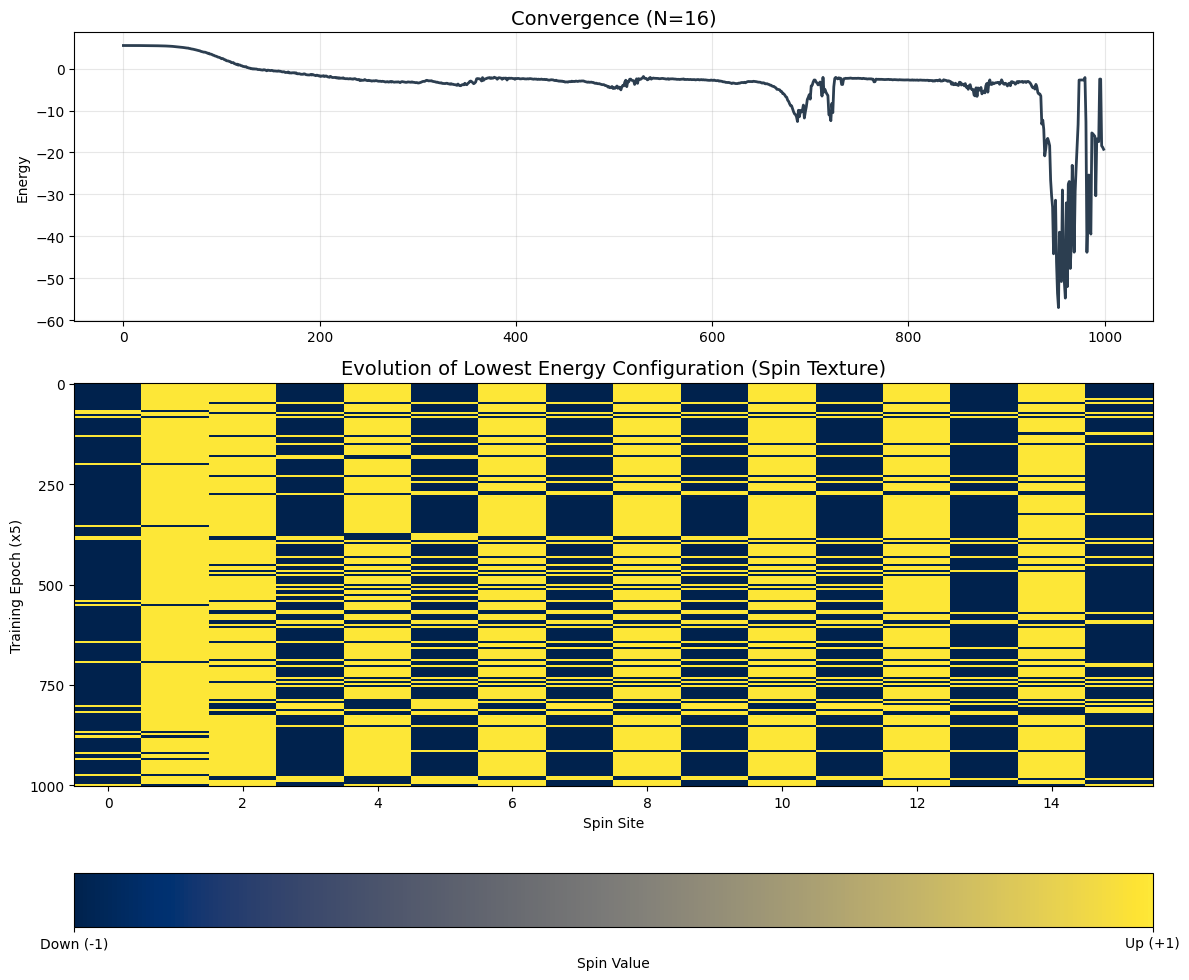

In [13]:
print("\n========== PART 2: N=16 Large System Visualization ==========")

large_config = {
    'n_spins': 16,  # Large system
    'J1': 1.0,
    'J2': 0.5, # Frustrated phase
    'lr': 0.0005,
    'n_epochs': 1000,
    'batch_size': 512,
    'mcmc_steps': 10,
    'depth_1': 32,
    'depth_2': 64,
    'kernel_size': 5,
    'device': torch.device("cuda" if torch.cuda.is_available() else "cpu")
}

e_hist, s_hist = train_vmc_sampling_largeN(ComplexCNN, compute_energy_complex_robust, large_config)

# Visualize
plot_large_system_vis(e_hist, s_hist, n_spins=16)